In [2]:
import numpy as np
from numpy import pi, sqrt
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import emcee

import corner
import pandas as pd

from scipy.optimize import curve_fit

import os
import saxs_helpers as sm

In [3]:
# Specify data file locations and file names
data_dir = '../../SAXS/SAXS Data/'

data_files = [
    'Dil_Salt/H_0N_100U.dat',   # 0
    'Dil_Salt/H_10N_100U.dat',  # 1
    'Dil_Salt/H_20N_100U.dat',  # 2
    'Dil_Salt/H_50N_100U.dat',  # 3
    'Dil_Salt/H_100N_100U.dat', # 4
    'Dil_Salt/H_200N_100U.dat', # 5

    'BE_Salt/BE_0N.dat',        # 6
    'BE_Salt/BE_10N.dat',       # 7
    'BE_Salt/BE_20N.dat',       # 8
    'BE_Salt/BE_50N.dat',       # 9
    
    'BE_Urea/BE_0N_0U.dat',     # 10
    'BE_Urea/BE_0N_50U.dat',    # 11
    'BE_Urea/BE_0N_100U.dat',   # 12
    'BE_Urea/BE_0N_200U.dat'    # 13
]

# Specify backend file locations and file names
backend_dir = 'Backend files/'

backend_files = [
    'backend_H_0N_100U.h5',
    'backend_H_10N_100U.h5',
    'backend_H_20N_100U.h5',
    'backend_H_50N_100U.h5',
    'backend_H_100N_100U.h5',
    'backend_H_200N_100U.h5',

    'backend_BE_0N.h5',
    'backend_BE_10N.h5',
    'backend_BE_20N.h5',
    'backend_BE_50N.h5',
    
    'backend_BE_0N_0U.h5',
    'backend_BE_0N_50U.h5',
    'backend_BE_0N_100U.h5',
    'backend_BE_0N_200U.h5'
]

In [4]:
# Parameter labels
labels_cyl = ["$r_{cyl}$", "$σ_{cyl}$", "$L$"]
labels_lam = ["$d$", "$σ_{d}$", "$N_{layers}$", "$η$"]
labels_ves = ["$r_{ves}$", "$σ_{ves}$"]
labels_material = ["$t$", "$Δρ$"]
labels_scb = ["$A_{cyl}$", "$A_{lam}$", "$A_{ves}$", "$A_{h}$", "$B$"]
labels = labels_cyl + labels_lam + labels_ves + labels_material + labels_scb

In [5]:
# Function to inspect walker traces
def showWalkers(file_num, burnin, thin):
    
    # Load emcee backend file
    backend_filename = data_dir + backend_dir + backend_files[file_num]
    reader = emcee.backends.HDFBackend(backend_filename)
    
    # Show walkers
    sm.show_walker_traces(reader, burnin=burnin, thin=thin, labs=labels)

# Function to generate corner plots to identify parameter correlations
def showCornerPlots(file_num, param_inds):
    
    # Load emcee backend file
    backend_filename = data_dir + backend_dir + backend_files[file_num]
    reader = emcee.backends.HDFBackend(backend_filename)
    
    # Get the flattened samples after burn-in and thinning
    samples = reader.get_chain(discard=burnin, thin=thin, flat=True)

    # Labels for parameters of interest
    labs = [labels[i] for i in param_inds]
    
    # Corner plot for selected indices
    corner.corner(samples[:, param_inds], labels=labs)
    plt.show()

In [6]:
for file_num in range(len(backend_files)):
    # Load emcee backend file
    backend_filename = data_dir + backend_dir + backend_files[file_num]
    reader = emcee.backends.HDFBackend(backend_filename)
    samples = reader.get_chain(discard=0, thin=1, flat=False)
    print(samples.shape)

(20000, 80, 16)
(20000, 80, 16)
(20000, 80, 16)
(20000, 80, 16)
(20000, 80, 16)
(20000, 80, 16)
(20000, 80, 16)
(20000, 80, 16)
(20000, 80, 16)
(20000, 80, 16)
(20000, 80, 16)
(20000, 80, 16)
(20000, 80, 16)
(20000, 80, 16)


### Inspect walker traces for convergence and identify burn-in times

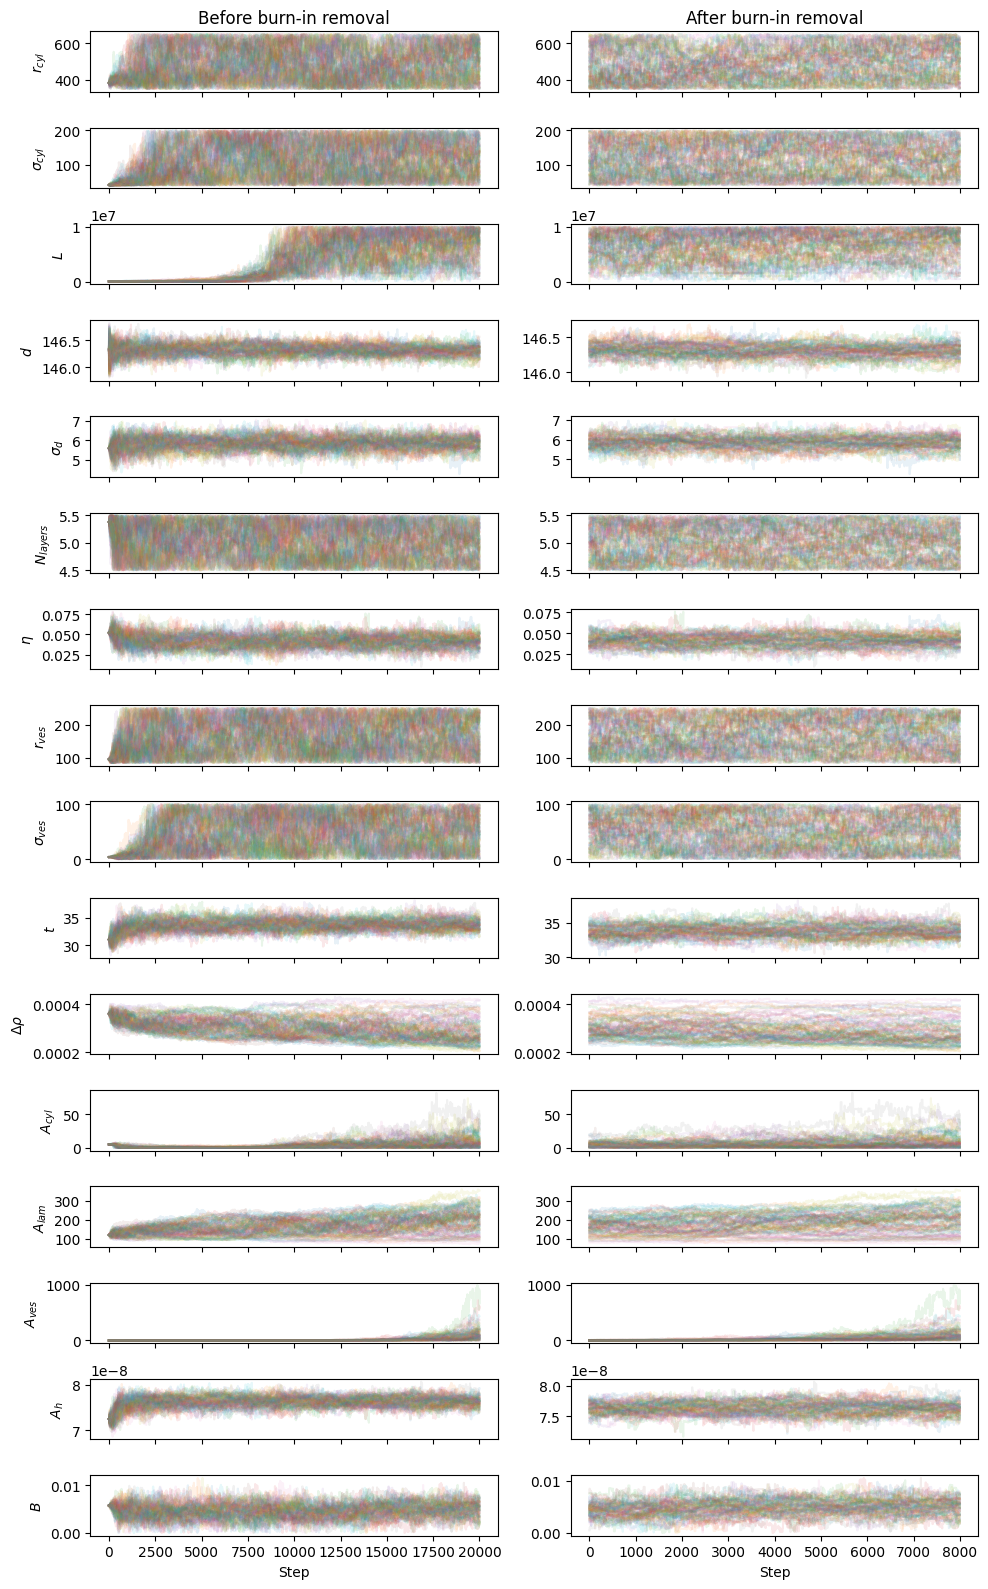

In [8]:
file_num = 0

burnin = 12000
thin = 10

showWalkers(file_num, burnin, thin)

### Show corner plots to identify parameter correlations

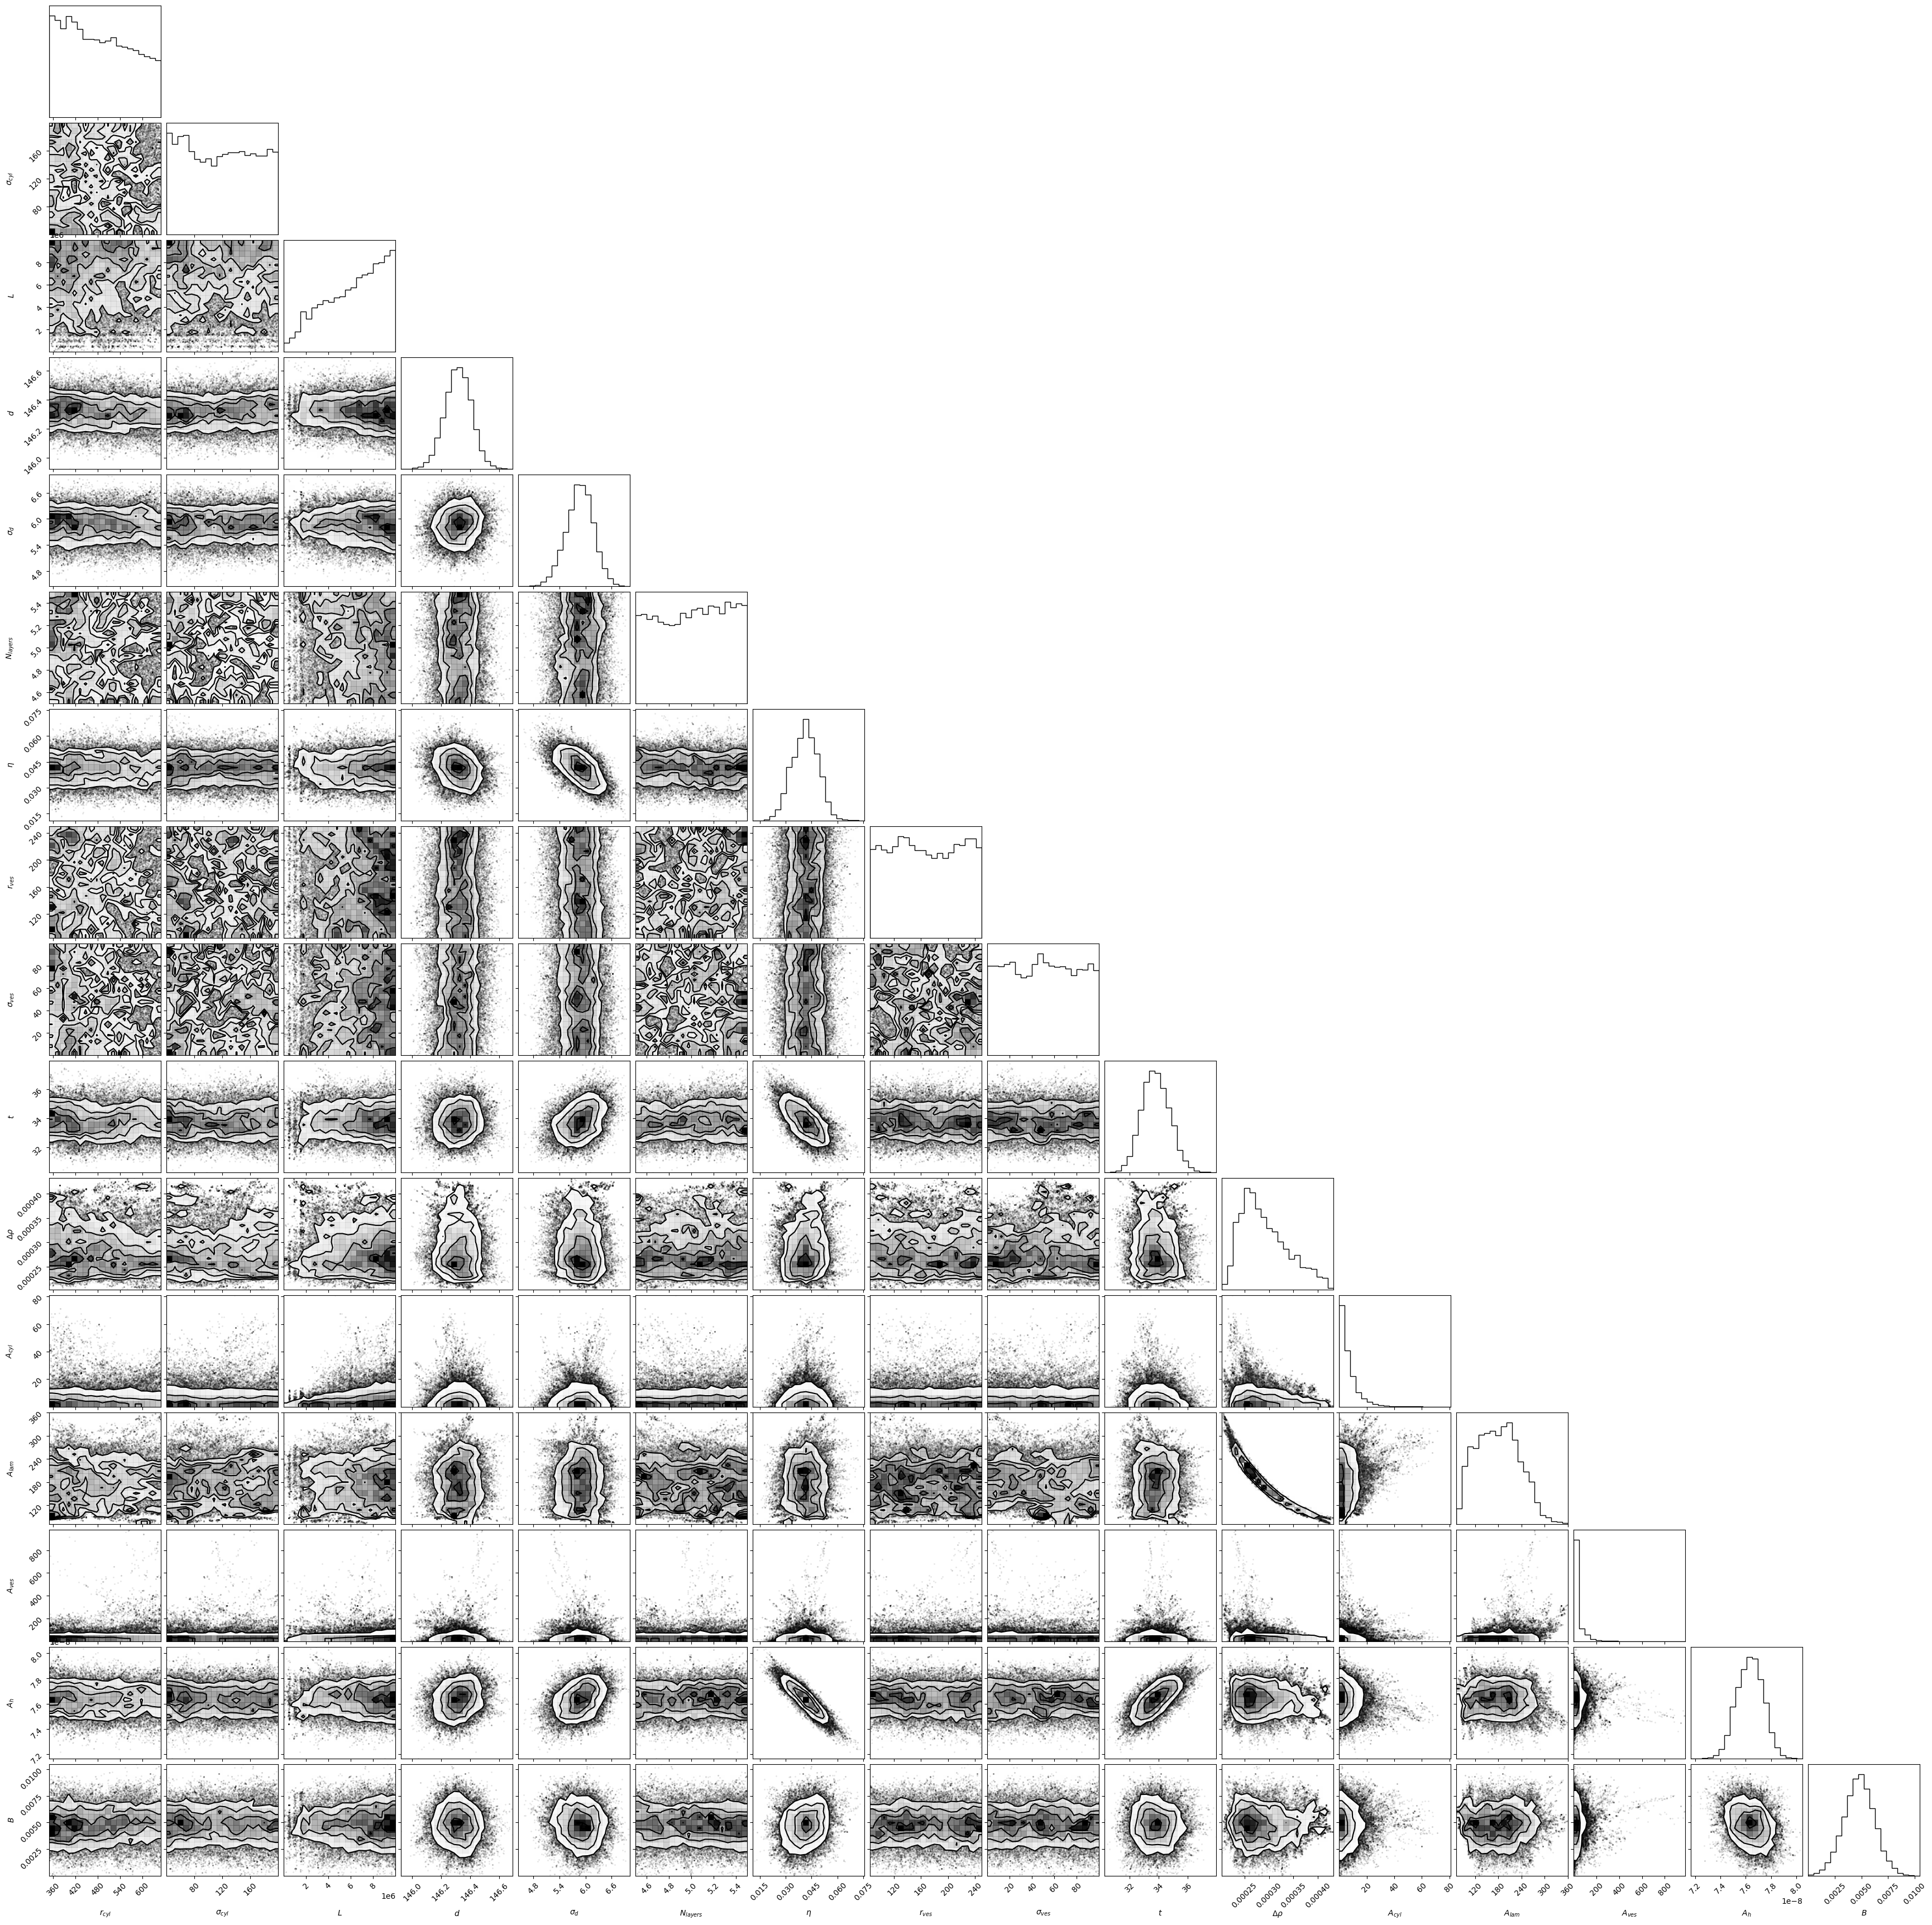

In [10]:
# Only show parameters of interest
param_inds = [0, 1,   # r_cyl, sigma_cyl,
              3, 4,   # d_spacing, sigma_d_spacing
              9, 10,  # thickness, sld contrast
              11, 12  # A_cyl, A_lam
             ]
#showCornerPlots(file_num, param_inds)
showCornerPlots(file_num, np.arange(len(labels)))

# Dilution salt series

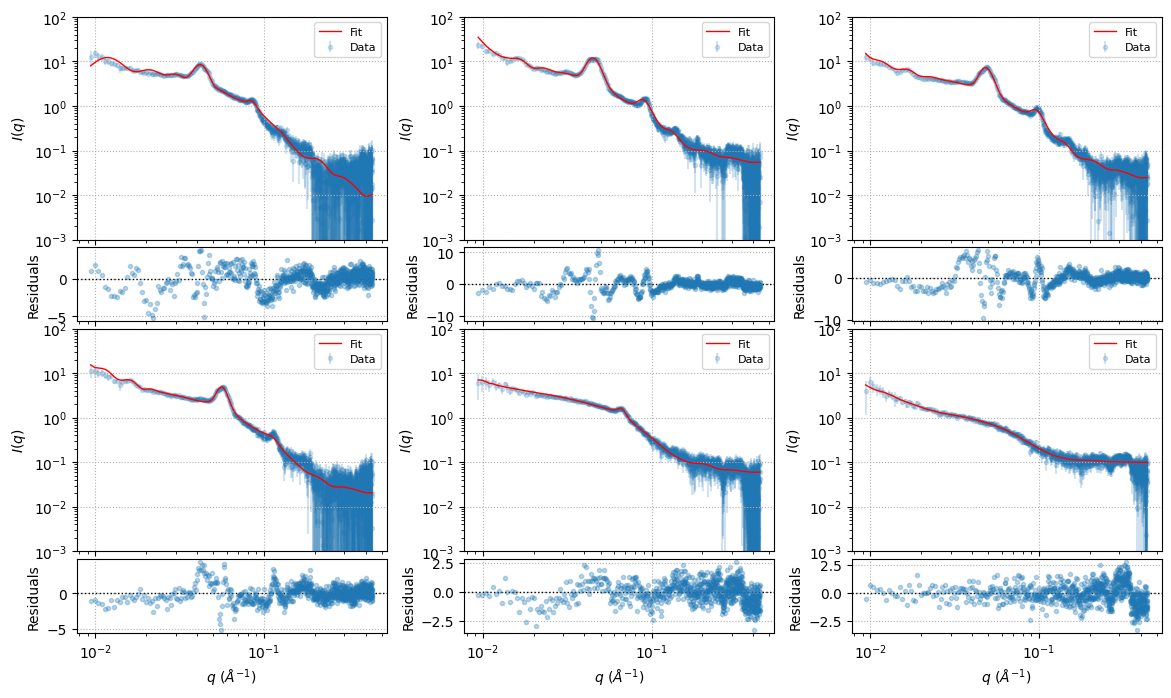

In [12]:
plt.figure(figsize=(14, 8))
gs = gridspec.GridSpec(4, 3, height_ratios=[3, 1, 3, 1], hspace=0.05, wspace=0.25)

map_params_dil = []

for i, file_num in enumerate(range(0, 6)):
    
    # Load original data file
    data_file = data_dir + data_files[file_num]
    q, Iq, err_Iq = sm.loadDatFile(data_file)
    
    # Load emcee backend file
    backend_filename = data_dir + backend_dir + backend_files[file_num]
    reader = emcee.backends.HDFBackend(backend_filename)

    # Get MAP parameters and compute Iq_fit
    samples, log_prob, theta_map = sm.getSamplesLogProbThetaMap(reader, burnin=burnin, thin=thin)
    Iq_fit = sm.combined_model(q, *theta_map)
    map_params_dil.append(theta_map)

    # Data and fits
    row = (i // 3) * 2
    col = i % 3
    ax_main = plt.subplot(gs[row, col])
    ax_main.errorbar(q, Iq, yerr=err_Iq, fmt='.', alpha=0.2, label="Data", zorder=1)
    ax_main.plot(q, Iq_fit, color='r', linewidth=1, label="Fit", zorder=2)
    ax_main.set_xscale('log')
    ax_main.set_yscale('log')
    ax_main.set_ylim(1e-3, 1e2)
    ax_main.grid(linestyle=':')
    ax_main.legend(fontsize=8)
    ax_main.set_ylabel('$I(q)$')
    plt.setp(ax_main.get_xticklabels(), visible=False)

    # Residuals
    ax_res = plt.subplot(gs[row + 1, col], sharex=ax_main)
    residuals = (Iq - Iq_fit) / err_Iq
    ax_res.axhline(0, color='k', linewidth=1, linestyle=':')
    ax_res.plot(q, residuals, '.', alpha=0.3)
    ax_res.set_xscale('log')
    ax_res.set_xlabel('$q\ (Å^{-1})$')
    ax_res.set_ylabel('Residuals')
    ax_res.grid(linestyle=':')

plt.show()

map_params_dil = np.array(map_params_dil)

y0 = 13.79 ± 2.64
A  = 993.03 ± 39.38
I0 = 56.13 ± 2.31


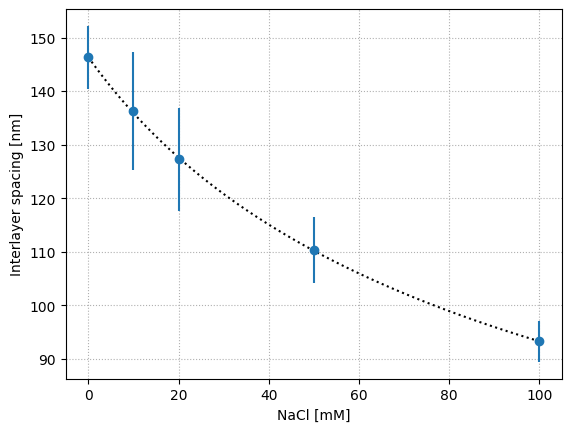

In [13]:
# Plot the inferred interlayer spacing values versus NaCl concentration.

x = np.array([0, 10, 20, 50, 100])
y = np.zeros_like(x, dtype=float)
dy = np.zeros_like(x, dtype=float)

for file_num in range(len(x)):
    backend_filename = data_dir + backend_dir + backend_files[file_num]
    reader = emcee.backends.HDFBackend(backend_filename)
    samples = reader.get_chain(discard=burnin, thin=thin, flat=True)

    # Layer spacing and polydispersity
    y[file_num] = np.mean(samples[:,3])
    dy[file_num] = np.mean(samples[:,4])

# Define model
def debye_model(x, y0, A, I0):
    # y0: physical minimum spacing
    # A: 
    # I0: ionic strength of the buffer at 0 mM NaCl
    return y0 + A / np.sqrt(I0 + x)

p0 = [13, 1e3, 50]
popt, pcov = curve_fit(debye_model, x, y, sigma=dy, p0=p0)
y0_fit, A_fit, I0_fit = popt
perr = np.sqrt(np.diag(pcov))
y0_err, A_err, I0_err = perr

print(f"y0 = {y0_fit:.2f} ± {y0_err:.2f}")
print(f"A  = {A_fit:.2f} ± {A_err:.2f}")
print(f"I0 = {I0_fit:.2f} ± {I0_err:.2f}")

x_fit = np.linspace(min(x), max(x), 100)
y_fit = debye_model(x_fit, *popt)

plt.errorbar(x, y, yerr=dy, fmt='.', markersize=12)
plt.plot(x_fit,y_fit,'k:')
plt.xlabel('NaCl [mM]')
plt.ylabel('Interlayer spacing [nm]')
plt.grid(linestyle=':')
plt.show()

# Buffer exchange salt series

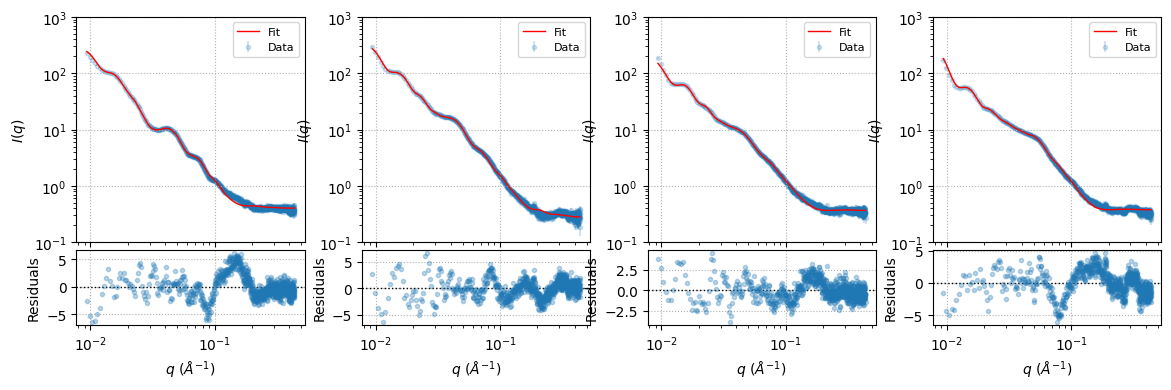

In [15]:
plt.figure(figsize=(14, 4))
gs = gridspec.GridSpec(2, 4, height_ratios=[3, 1], hspace=0.05, wspace=0.25)

for i, file_num in enumerate(range(6, 10)):
    
    # Load original data file
    data_file = data_dir + data_files[file_num]
    q, Iq, err_Iq = sm.loadDatFile(data_file)
    
    # Load emcee backend file
    backend_filename = data_dir + backend_dir + backend_files[file_num]
    reader = emcee.backends.HDFBackend(backend_filename)

    # Get MAP parameters and compute Iq_fit
    samples, log_prob, theta_map = sm.getSamplesLogProbThetaMap(reader, burnin=burnin, thin=thin)
    Iq_fit = sm.combined_model(q, *theta_map)

    # Data and fits
    ax_main = plt.subplot(gs[0, i])
    ax_main.errorbar(q, Iq, yerr=err_Iq, fmt='.', alpha=0.2, label="Data", zorder=1)
    ax_main.plot(q, Iq_fit, color='r', linewidth=1, label="Fit", zorder=2)
    ax_main.set_xscale('log')
    ax_main.set_yscale('log')
    ax_main.set_ylim(1e-1, 1e3)
    ax_main.grid(linestyle=':')
    ax_main.legend(fontsize=8)
    ax_main.set_xlabel('$q\ (Å^{-1})$')
    ax_main.set_ylabel('$I(q)$')
    plt.setp(ax_main.get_xticklabels(), visible=False)

    # Residuals
    ax_res = plt.subplot(gs[1, i], sharex=ax_main)
    residuals = (Iq - Iq_fit) / err_Iq
    ax_res.axhline(0, color='k', linewidth=1, linestyle=':')
    ax_res.plot(q, residuals, '.', alpha=0.3)
    ax_res.set_xscale('log')
    ax_res.set_xlabel('$q\ (Å^{-1})$')
    ax_res.set_ylabel('Residuals')
    ax_res.grid(linestyle=':')

plt.show()

# Buffer exchange urea series

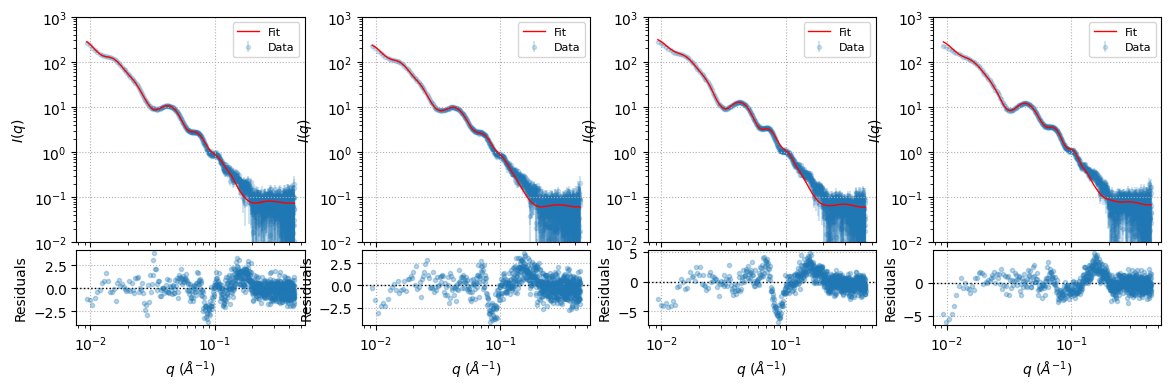

In [17]:
plt.figure(figsize=(14, 4))
gs = gridspec.GridSpec(2, 4, height_ratios=[3, 1], hspace=0.05, wspace=0.25)

for i, file_num in enumerate(range(10, 14)):
    
    # Load original data file
    data_file = data_dir + data_files[file_num]
    q, Iq, err_Iq = sm.loadDatFile(data_file)
    
    # Load emcee backend file
    backend_filename = data_dir + backend_dir + backend_files[file_num]
    reader = emcee.backends.HDFBackend(backend_filename)

    # Get MAP parameters and compute Iq_fit
    samples, log_prob, theta_map = sm.getSamplesLogProbThetaMap(reader, burnin=burnin, thin=thin)
    Iq_fit = sm.combined_model(q, *theta_map)

    # Data and fits
    ax_main = plt.subplot(gs[0, i])
    ax_main.errorbar(q, Iq, yerr=err_Iq, fmt='.', alpha=0.2, label="Data", zorder=1)
    ax_main.plot(q, Iq_fit, color='r', linewidth=1, label="Fit", zorder=2)
    ax_main.set_xscale('log')
    ax_main.set_yscale('log')
    ax_main.set_ylim(1e-2, 1e3)
    ax_main.grid(linestyle=':')
    ax_main.legend(fontsize=8)
    ax_main.set_xlabel('$q\ (Å^{-1})$')
    ax_main.set_ylabel('$I(q)$')
    plt.setp(ax_main.get_xticklabels(), visible=False)

    # Residuals
    ax_res = plt.subplot(gs[1, i], sharex=ax_main)
    residuals = (Iq - Iq_fit) / err_Iq
    ax_res.axhline(0, color='k', linewidth=1, linestyle=':')
    ax_res.plot(q, residuals, '.', alpha=0.3)
    ax_res.set_xscale('log')
    ax_res.set_xlabel('$q\ (Å^{-1})$')
    ax_res.set_ylabel('Residuals')
    ax_res.grid(linestyle=':')

plt.show()